In [60]:
%matplotlib inline
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(1)

In [61]:
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)
from src.utils import *
import src.utils as ut

In [62]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']

PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']

PATH2 = PATHS['PATH_LIGHT_CURVES_OGLE']

lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')


In [63]:
df_ogle_dr3 = pd.concat([lc_test, lc_train])

df_ogle_dr3.drop(axis='columns', columns=['Pred', 'Pred2', 'h', 'e', 'u', 'label', 'Unnamed: 0'], inplace=True)

print(df_ogle_dr3.shape)

df_ogle_dr3.dropna(inplace=True)

print(df_ogle_dr3.shape)

(420126, 64)
(420126, 64)


In [64]:
# Remove the '.dat' extension
df_ogle_dr3['cleaned_ID'] = df_ogle_dr3['ID'].str.replace('.dat', '')

# Split the column into four new columns
df_ogle_dr3[['survey', 'field', 'star_type', 'id_number']] = df_ogle_dr3['cleaned_ID'].str.split('-', expand=True)

df_ogle_dr3.drop(axis='columns', columns=['cleaned_ID', 'survey', 'id_number'], inplace=True)

df_ogle_dr3 = df_ogle_dr3[df_ogle_dr3.star_type.isin(['RRLYR', 'CEP', 'ECL', 'LPV', 'DSCT'])]

df_ogle_dr3.star_type.unique()


array(['ECL', 'RRLYR', 'CEP', 'LPV', 'DSCT'], dtype=object)

In [65]:
df_to_train = df_ogle_dr3.drop(axis='columns', columns=['field', 'ID'])

label = df_to_train['star_type']

del df_to_train['star_type']

clf = RandomForestClassifier(max_depth=5, random_state=0)

clf.fit(df_to_train, label)

soft_prediction =  clf.predict_proba(df_to_train)

soft_prediction

In [ ]:

print(soft_prediction[0])
print(clf.classes_)

[0.03346542 0.02261655 0.73707963 0.08485996 0.12197844]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [ ]:
soft_prediction.shape

(419257, 5)

In [ ]:
print(soft_prediction[1])
print(clf.classes_)

[0.06843455 0.01186934 0.04364658 0.0266148  0.84943472]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [ ]:
df_to_train[['soft_pred_cep','soft_pred_dsct', 'soft_pred_ecl','soft_pred_lpv','soft_pred_rrlyr']] = soft_prediction

for column in ['soft_pred_cep','soft_pred_dsct', 'soft_pred_ecl','soft_pred_lpv','soft_pred_rrlyr']: 
    df_to_train[column+'_2'] = df_to_train[column]*df_to_train[column]

In [ ]:
T = 1
df_to_train['h'] = (1 -  df_to_train['soft_pred_cep_2'] - df_to_train['soft_pred_dsct_2'] - df_to_train['soft_pred_ecl_2']
                    - df_to_train['soft_pred_lpv_2']- df_to_train['soft_pred_rrlyr_2'])


factor = T*df_to_train['h'] 

df_to_train['e'] = np.exp(-factor)

df_to_train['u'] = np.random.uniform(0, 1, df_to_train.shape[0])

df_to_train['u']

0         0.919449
1         0.243994
2         0.981841
3         0.512853
4         0.635676
            ...   
391496    0.846145
391497    0.325836
391498    0.310643
391499    0.170037
391500    0.782164
Name: u, Length: 419257, dtype: float64

In [ ]:
df_to_train[['label', 'field', 'ID']] = pd.DataFrame({
    'label': label,
    'field': df_ogle_dr3['field'].values,
    'ID': df_ogle_dr3['ID'].values
})

In [ ]:
data_test  = df_to_train[(df_to_train['e']<= df_to_train['u'])]
print(data_test.shape)
print(data_test.label.value_counts())
data_train = df_to_train[(df_to_train['e']> df_to_train['u'])]
print(data_train.shape)
print(data_train.label.value_counts())


(43154, 79)
LPV      14956
RRLYR    12323
ECL      10768
CEP       3790
DSCT      1317
Name: label, dtype: int64
(376103, 79)
LPV      309022
ECL       31019
RRLYR     30410
CEP        4162
DSCT       1490
Name: label, dtype: int64


<AxesSubplot:>

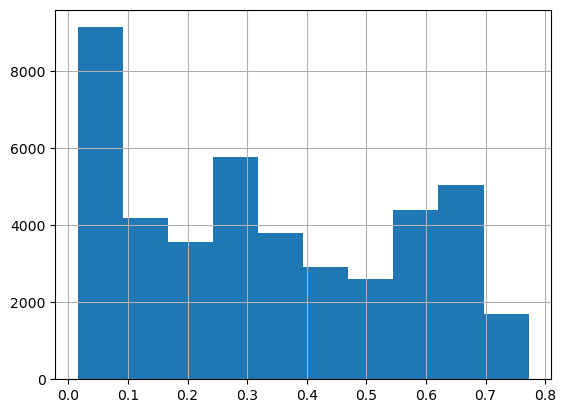

In [ ]:
data_test.h.hist()

<AxesSubplot:>

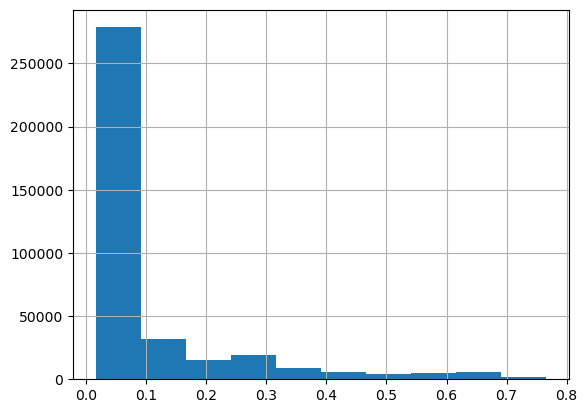

In [ ]:
data_train.h.hist()

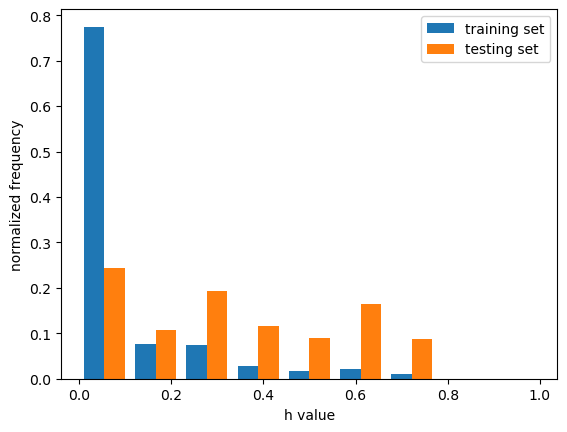

In [ ]:
#sets up the axis and gets histogram data
x = data_train.h
y = data_test.h
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])
bins = np.linspace(0, 1, 10)
plt.hist([x, y], bins, weights=[x_w, y_w], label=['training set', 'testing set'])
plt.legend(loc='upper right')
plt.xlabel('h value')
plt.ylabel('normalized frequency')
plt.show()

In [ ]:
data_train.to_csv('train_OGLEDR3_T1.csv')

In [ ]:
data_test.to_csv('test_OGLEDR3_T1.csv')